In [2]:
import torch
import numpy as np
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import Subset, Dataset, DataLoader

import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Dataset size: torch.Size([60000, 28, 28])


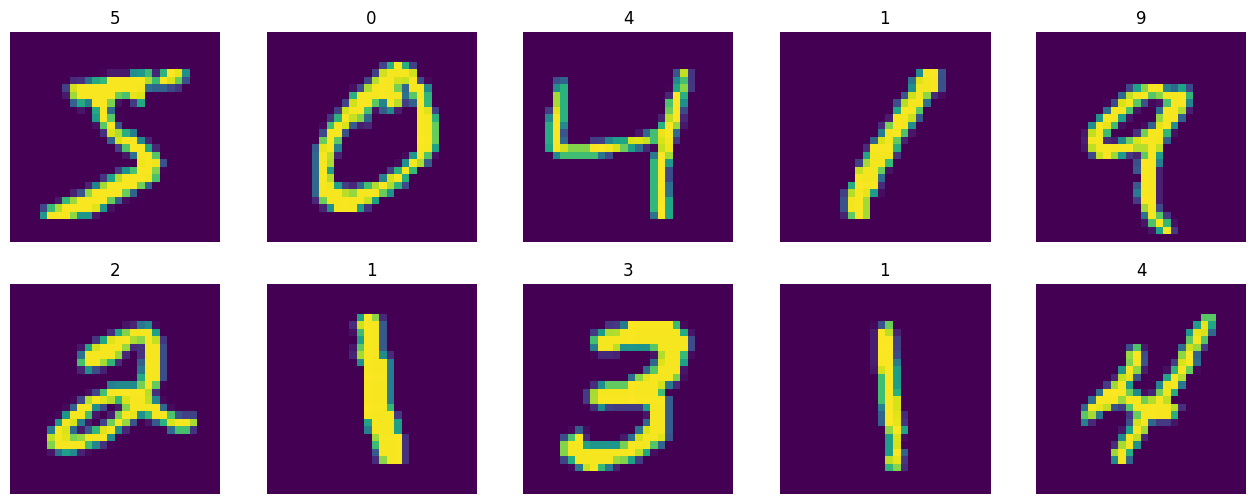

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)
mnist_dataset = torchvision.datasets.MNIST(root='./',train=True,transform=transform,download=True)
print(f'Dataset size: {mnist_dataset.data.size()}')
fig = plt.figure(figsize=(16,6))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    ax.imshow(mnist_dataset.data[i])
    ax.set_title(mnist_dataset.targets[i].item())
    ax.axis('off')

In [4]:
# MNIST.__getitem__ casts the array to numpy resulting in error if data is on cuda
# mnist_dataset.data = mnist_dataset.data.to(device)
# mnist_dataset.targets = mnist_dataset.targets.to(device)
mnist_valid_dataset = Subset(mnist_dataset,torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset,torch.arange(10000,len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root='./',train=False,transform=transform,download=True)

In [5]:
batch_size = 64
torch.manual_seed(47)
train_dl = DataLoader(mnist_train_dataset,batch_size,shuffle=True,pin_memory=True)
validation_dl = DataLoader(mnist_valid_dataset,batch_size,shuffle=True,pin_memory=True)

In [6]:
model = nn.Sequential(
    nn.Conv2d(1,32,5,padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32,64,5,padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(3136,1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024,10)
)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

In [7]:
num_epochs = 20
loss_hist_train = [0]*num_epochs
accuracy_hist_train = [0]*num_epochs
loss_hist_val = [0]*num_epochs
accuracy_hist_val = [0]*num_epochs

for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_dl:
        x_batch, y_batch = x_batch.to(device),y_batch.to(device)
        preds = model(x_batch)
        loss = loss_fn(preds,y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist_train[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(preds,dim=1) == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.sum().item()
    loss_hist_train[epoch] /= len(train_dl.dataset)
    accuracy_hist_train[epoch] /= len(train_dl.dataset)

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in validation_dl:
            x_batch, y_batch = x_batch.to(device),y_batch.to(device)
            preds = model(x_batch)
            loss = loss_fn(preds,y_batch)
            loss_hist_val[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(preds,dim=1) == y_batch).float()
            accuracy_hist_val[epoch] += is_correct.sum().item()
    loss_hist_val[epoch] /= len(validation_dl.dataset)
    accuracy_hist_val[epoch] /= len(validation_dl.dataset)

    print(f'Epoch {epoch+1} accuracy: '
          f'{accuracy_hist_train[epoch]:.4f} val_accuracy '
          f'{accuracy_hist_val[epoch]:.4f}'
    )

Epoch 1 accuracy: 0.9523 val_accuracy0.9823
Epoch 2 accuracy: 0.9859 val_accuracy0.9875
Epoch 3 accuracy: 0.9894 val_accuracy0.9871
Epoch 4 accuracy: 0.9924 val_accuracy0.9879
Epoch 5 accuracy: 0.9937 val_accuracy0.9895
Epoch 6 accuracy: 0.9951 val_accuracy0.9912
Epoch 7 accuracy: 0.9951 val_accuracy0.9895
Epoch 8 accuracy: 0.9966 val_accuracy0.9896
Epoch 9 accuracy: 0.9961 val_accuracy0.9898
Epoch 10 accuracy: 0.9972 val_accuracy0.9900
Epoch 11 accuracy: 0.9973 val_accuracy0.9891
Epoch 12 accuracy: 0.9968 val_accuracy0.9905
Epoch 13 accuracy: 0.9976 val_accuracy0.9894
Epoch 14 accuracy: 0.9980 val_accuracy0.9887
Epoch 15 accuracy: 0.9979 val_accuracy0.9899
Epoch 16 accuracy: 0.9979 val_accuracy0.9878
Epoch 17 accuracy: 0.9981 val_accuracy0.9897
Epoch 18 accuracy: 0.9979 val_accuracy0.9904
Epoch 19 accuracy: 0.9983 val_accuracy0.9909
Epoch 20 accuracy: 0.9987 val_accuracy0.9901


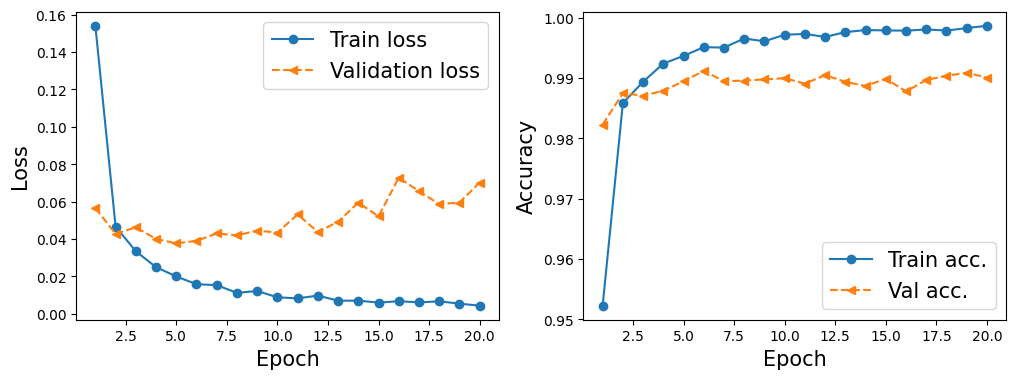

In [8]:
x_arr = np.arange(len(loss_hist_train)) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr,loss_hist_train,'-o',label='Train loss')
ax.plot(x_arr,loss_hist_val,'--<',label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch',size=15)
ax.set_ylabel('Loss',size=15)
ax = fig.add_subplot(1,2,2)
ax.plot(x_arr,accuracy_hist_train,'-o',label='Train acc.')
ax.plot(x_arr,accuracy_hist_val,'--<',label='Val acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch',size=15)
ax.set_ylabel('Accuracy',size=15)
plt.show()